# Классификация текстов

Взять ноутбук colab_text_classification_part1.ipynb который разбирали на занятии и добавить пункты которые мы пропустили
1. Проверьте повысилось ли качество на стандартных подходах при лемматизации/и без неё
2. Удалите/(замените на тег) из текстов сущности(имена, локации, что-то ещё). Запустите классификатор и модельки на сеточках
3. Сделайте выводы

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

In [3]:
print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


In [4]:
train_df.head(5)

,is_positive,review
0,0,"Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...


In [5]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 66.73%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

**Done**  Took two lists of words and cut them both to the third part, reviewing the words one by one.  
The whole corpus didn't improve the results, even worsened a bit. In three tries the result gave the target 71%.

Original words' lists:
https://ptrckprry.com/course/ssd/data/positive-words.txt
https://ptrckprry.com/course/ssd/data/negative-words.txt

In [6]:
with open('positive_words.txt', 'r') as p:
    pos = p.read()
    positive_w = pos.split('\n')
    
with open('negative_words.txt', 'r') as n:
    neg = n.read()
    negative_w = neg.split('\n')


In [7]:
positive_w[:5]

['admired', 'admiring', 'admiringly', 'adorable', 'adored']

In [8]:
positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_w))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_w))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))


Test accuracy = 71.68%


**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [9]:
import re
pattern = re.compile('<br />')

In [10]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

**Vectorizing**

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()


In [12]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

In [13]:
vectorizer.get_feature_names_out()

array(['00', '000', '0000000000001', ..., 'østbye', 'über', 'üvegtigris'],
      dtype=object)

In [14]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


In [16]:
vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

In [17]:
model.fit(train_df['review'], train_df['is_positive'])

C:\Users\Armik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [18]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.37%


**Visualizing weights with eli5**

In [19]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=20)

**NB: since scikit-learn==0.22 the words in a given text are not highlighted anymore and tokens are given as features**

In [20]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, top=20,
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [21]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, top=20,
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [22]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, top=20,
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


In [23]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, top=20, targets=['positive'], target_names=['negative', 'positive'])

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.28%


**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [25]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.64%


**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [26]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

C:\Users\Armik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test accuracy = 87.86%


In [27]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, top=20,
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [28]:
import spacy
from spacy import displacy
import en_core_web_sm
#import en

nlp = spacy.load("en_core_web_sm")

#nlp = spacy.load('en', disable=['parser'])

#

In [29]:
lemmatizer = nlp.get_pipe("lemmatizer")
print(lemmatizer.mode)  # 'rule'


rule


In [30]:
docs = [nlp(doc) for doc in train_df.review.values]

In [31]:
lemmas = []
for doc in docs:
    lemma = []
    for token in doc:
        lemma.append(''.join(token.lemma_))
    lemmas.append(' '.join(lemma))


In [32]:
lemmas[2]

'I simply love this movie . I also love the Ramones , so I be sorta biased to begin with in the first place . there be not a lot of critical praise to give this film , either you like it or you do not . I think it be a great cult movie .'

In [33]:
train_df['lemmas'] = lemmas

In [34]:
train_df['lemmas'][0]

'dreamgirl , despite its fistful of Tony win in an incredibly weak year on Broadway , have never be what one would call a jewel in the crown of stage musical . however , that be not to say that in the right cinematic hand it could not be flesh out and polish into something worthwhile on - screen . unfortunately , what transfer to the screen be basically a slavishly faithful version of the stage hit with all of its inherent weakness intact . first , the score have never be one of the strong point of this production and the film do not change that factor . there be lot of song ( perhaps too many ? ) , but few of they be especially memorable . the close any come to catchy tune be the title song and one night only - the much acclaimed and I be tell you that I be not go be less a great song than it be a dramatic set piece for the character of Effie ( Jennifer Hudson ) . the film be slick and technically well - produce , but the story and character be surprisingly thin and lack in any resona

In [35]:
docs_test = [nlp(doc) for doc in test_df.review.values]

In [36]:
lemmas_test = []
for doc in docs_test:
    lemma_t = []
    for token in doc:
        lemma_t.append(''.join(token.lemma_))
    lemmas_test.append(' '.join(lemma_t))


In [37]:
test_df_lemma = test_df.copy()

In [38]:
test_df_lemma['review'] = lemmas_test

In [39]:
test_df_lemma.tail(2)

,is_positive,review
24998,1,this move be intriguing and absorbing ; howeve...
24999,1,film about the failure of government and the s...


**Задание** Сделайте классификатор на лемматизированных текстах.

In [40]:
vectorizer_lem = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier_lem = LogisticRegression()

model_lem = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model_lem.fit(train_df['lemmas'], train_df['is_positive'])

eval_model(model_lem, test_df_lemma)

Test accuracy = 87.94%


In [41]:
from nltk.stem.porter import *

stemmer = PorterStemmer()

**Задание** Попробуйте вместо лемм классифицировать основы.

In [42]:
def get_stems(pd_series):
    stems_list = []
    for text in pd_series.values:
        stem = [stemmer.stem(word) for word in text.split(' ')]
        stems_list.append(' '.join(stem))
    return stems_list

In [43]:
stem_list_train = get_stems(train_df['review'])

In [44]:
stem_list_train[2]

"i simpli love thi movie. i also love the ramones, so i am sorta bias to begin with in the first place. there isn't a lot of critic prais to give thi film, either you like it or you don't. i think it' a great cult movie."

In [45]:
train_df['stems'] = stem_list_train

In [46]:
train_df.tail(2)

,is_positive,review,lemmas,stems
24998,1,Saw this film on DVD yesterday and was gob-sma...,see this film on dvd yesterday and be gob - sm...,saw thi film on dvd yesterday and wa gob-smack...
24999,0,This was a disappointment - none of the nuance...,this be a disappointment - none of the nuance ...,thi wa a disappoint - none of the nuanc of the...


In [47]:
stem_list_test = get_stems(test_df['review'])

In [48]:
test_df_stems = test_df.copy()

In [49]:
test_df_stems['review'] = stem_list_test

In [50]:
vectorizer_stem = TfidfVectorizer(ngram_range=(2, 4), max_features=20000, analyzer='char')
classifier_stem = LogisticRegression()

model_stem = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model_stem.fit(train_df['stems'], train_df['is_positive'])

eval_model(model_stem, test_df_stems)

C:\Users\Armik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test accuracy = 87.64%


**quite amazed it's not worse**

**Finding and tagging entities**

In [51]:
displacy.render(docs[0], style='ent', jupyter=True)


**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

In [52]:
entities = []
for doc in docs:
    entity = []
    for ent in doc.ents:
        entity.append(f'{ent.label_}, | , {ent.text}')
    entities.append(' '.join(entity))


In [53]:
entities[2]

'ORG, | , Ramones ORDINAL, | , first'

In [54]:
docs[2].text

"I simply love this movie. I also love the Ramones, so I am sorta biased to begin with in the first place. There isn't a lot of critical praise to give this film, either you like it or you don't. I think it's a great cult movie."

<BarContainer object of 231 artists>

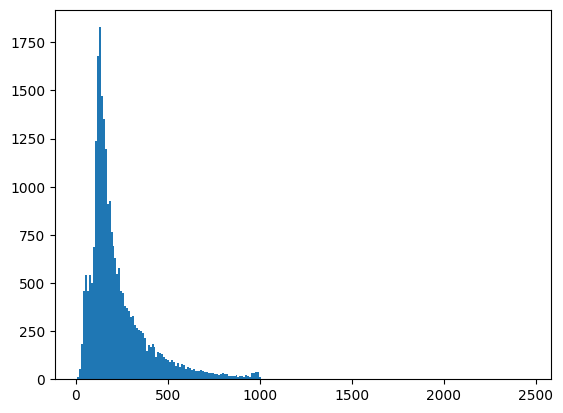

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

In [56]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 26783


**Задание** Сконвертируйте данные

In [57]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

C:\Users\Armik\AppData\Local\Temp\ipykernel_7300\1263189772.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.zeros((len(texts), max_text_len), dtype=np.int)
C:\Users\Armik\AppData\Local\Temp\ipykernel_7300\1263189772.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, c

In [58]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [59]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [60]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 64)          1714112   
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,714,883
Trainable params: 1,714,883
Non-trainable params: 0
______________________________________________

**Задание** Подсчитайте качество модели на тесте

In [61]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 19s 88ms/step - loss: 0.5989 - accuracy: 0.7391 - val_loss: 0.3959 - val_accuracy: 0.8428
Epoch 2/10
196/196 [==============================] - 18s 93ms/step - loss: 0.2969 - accuracy: 0.8813 - val_loss: 0.2981 - val_accuracy: 0.8724
Epoch 3/10
196/196 [==============================] - 18s 94ms/step - loss: 0.1831 - accuracy: 0.9311 - val_loss: 0.2906 - val_accuracy: 0.8783
Epoch 4/10
196/196 [==============================] - 18s 93ms/step - loss: 0.1042 - accuracy: 0.9680 - val_loss: 0.3106 - val_accuracy: 0.8752
Epoch 5/10
196/196 [==============================] - 18s 92ms/step - loss: 0.0506 - accuracy: 0.9888 - val_loss: 0.3481 - val_accuracy: 0.8720
Epoch 6/10
196/196 [==============================] - 18s 92ms/step - loss: 0.0217 - accuracy: 0.9972 - val_loss: 0.3875 - val_accuracy: 0.8702
Epoch 7/10
196/196 [==============================] - 18s 92ms/step - loss: 0.0091 - accuracy: 0.9994 - val_loss: 0.4204 - val_accuracy: